In [11]:
import operator
import os
from typing import Annotated

from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from pydantic import BaseModel
from typing_extensions import TypedDict
from IPython.display import Image, display


os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [3]:
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

model = ChatOpenAI(model="gpt-4o")

In [13]:
class Subjects(BaseModel):
    subjects: list[str]


class BestJoke(BaseModel):
    id: int


class Joke(BaseModel):
    joke: str


class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


class JokeState(TypedDict):
    subject: str


def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

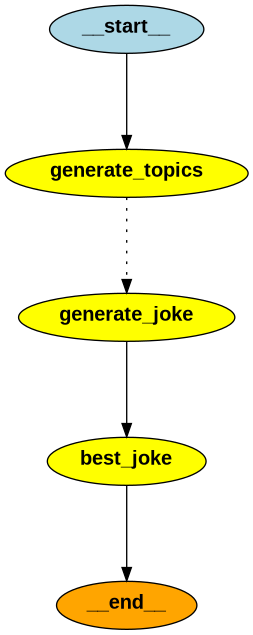

In [14]:
builder = StateGraph(OverallState)
builder.add_node("generate_topics", generate_topics)
builder.add_node("generate_joke", generate_joke)
builder.add_node("best_joke", best_joke)

builder.add_edge(START, "generate_topics")
builder.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
builder.add_edge("generate_joke", "best_joke")
builder.add_edge("best_joke", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_png()))

In [15]:
for s in graph.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['Wildlife Habitats', 'Animal Communication', 'Endangered Species Conservation']}}
{'generate_joke': {'jokes': ['Why did the fox put up a sign in its den?\n"For lease: Excellent wildlife accommodations—great views, close to squirrel transportation, and fast Wi-Fi in burrows!"']}}
{'generate_joke': {'jokes': ['Why did the parrot become a language teacher? Because it wanted to put its communication skills to good use!']}}
{'generate_joke': {'jokes': ["Why don’t endangered species ever lose at hide-and-seek? Because they've refined survival as an art!"]}}
{'best_joke': {'best_selected_joke': "Why don’t endangered species ever lose at hide-and-seek? Because they've refined survival as an art!"}}
